# Laplacian Renormalization Group (LGR)
## In a nutshell

In [1]:
import sys; sys.path.insert(0, "..")
from multifunbrain import *
#
flag_path = False
if not flag_path:
    path_root = Path.cwd().parent
    path_data =  path_root / Path("data")
    #
    os.chdir(path_root)
    flag_path = True
print(os.getcwd())

/home/opisthofulax/Documents/UniPa/projects/multifun-brain


## Multiscale Graph Spectral Analysis

### With 2 scales graph
- generate a multiscale graph with `multifunbrain.generate_multiscale_graph`.
- compute laplacian matrix $L$ and spectrum $\sigma(L)$
- draw the graph

In [ ]:
# generate a multiscale graph
G = generate_multiscale_graph(n_clusters=5, cluster_size=15, p_in=0.9, p_out=0.02, seed=42)
pos = nx.spring_layout(G, seed=42)
# compute the Laplacian spectrum
L = nx.laplacian_matrix(G).todense()
spectrum = nx.laplacian_spectrum(G)
#
fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(G, pos, with_labels=False, alpha=0.7)

Define the density matrix $\rho$ at time $\tau$ and compute the Entropy $S$ and specific heat $C$
$$
\rho(\tau) = \frac{e^{-\tau L}}{\mathrm{Tr}(e^{-\tau L})}, \qquad S = \mathrm{Tr}[\rho\log\rho], \qquad C = \frac{\mathrm{d}S}{\mathrm{d}(\log\tau)}
$$

In [ ]:
rho_m = lambda tau: rho_matrix(tau, L)
Sm1, Csp, VarL, t = entropy(spectrum, steps=600, t1=-2, t2=5)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 4))
#
color1 = "blue"
color2 = "red"
#
ax1.plot(t, Sm1, label=r"$1-S$", color=color1)
ax1.set_ylabel("1-S", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')
ax2 = ax1.twinx()
ax2.plot(t[:-1], Csp, label=r"$C$", color=color2)
ax2.set_ylabel("C", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_xlabel(r"$\tau$")
#
fig.tight_layout()

In [ ]:
tau = 1 / max(spectrum)
#
dists = symmetrized_inverse_distance(tau, rho_m)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')

In [ ]:
threshold = 0.01
optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
#
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
dendro = dendrogram(linkage_matrix, ax=ax[0], 
                    color_threshold=threshold,
                    above_threshold_color='k',
                    orientation='right')
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[str(label)] for label in label_list]
ax[0].set_xscale('log')
ax[0].set_xlim(tmin)
nx.draw(G, pos=pos, ax=ax[1], node_color=node_colors, alpha=0.7)

### With timeseries

In [2]:
ts = np.loadtxt(path_data / "HarvardOxford_48Parcels.ts.1D").T
G, remnodes = build_correlation_network(ts)

/home/opisthofulax/anaconda3/envs/multifun-brain/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/opisthofulax/anaconda3/envs/multifun-brain/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


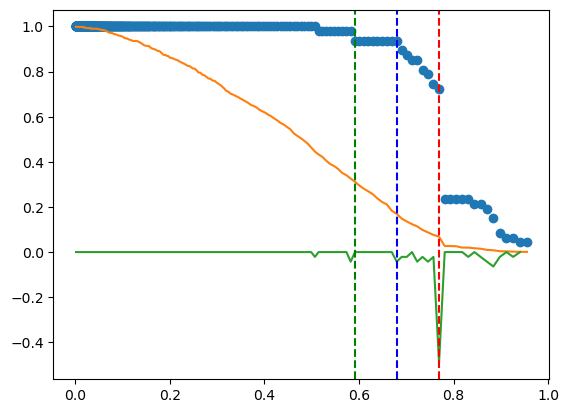

In [3]:
Th, Einf, Pinf = compute_threshold_stats(G)
#
Th1 = select_threshold_elbow(Th, Pinf)
Th2 = select_threshold_fraction(Th, Pinf)
Th3 = select_threshold_plateau(Th, Pinf, tol=0.07)
#
plt.plot(Th, Pinf, 'o')
plt.plot(Th, Einf)
plt.plot(Th[:-1], np.diff(Pinf))
plt.axvline(x=Th1, color='r', linestyle='--')
plt.axvline(x=Th2, color='g', linestyle='--')
plt.axvline(x=Th3, color='b', linestyle='--')

In [4]:
G, remnodes = build_correlation_network(ts, threshold=Th3)
print(remnodes)

[9, 34, 37, 33]


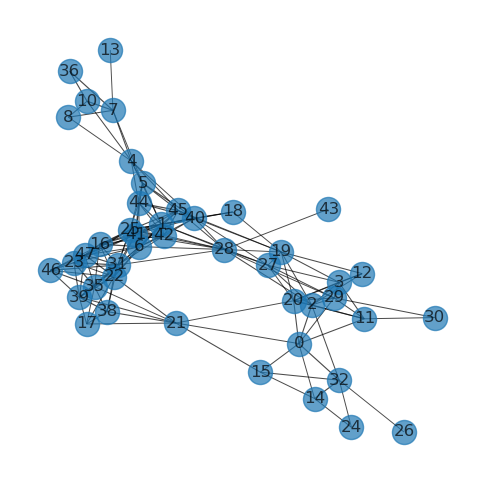

In [5]:
L = nx.laplacian_matrix(G).todense()
spectrum = nx.laplacian_spectrum(G)
#
fig, ax = plt.subplots(figsize=(6, 6))
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, with_labels=True, alpha=0.7, width=weights)

In [6]:
rho_m = lambda tau: rho_matrix(tau, L)
Sm1, Csp, VarL, t = entropy(spectrum)

/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


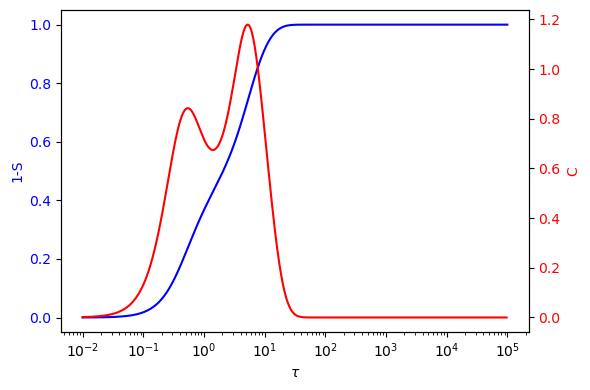

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
#
plot_entropy_and_C(ax, t, Sm1, Csp, color1="blue", color2="red")
fig.tight_layout()

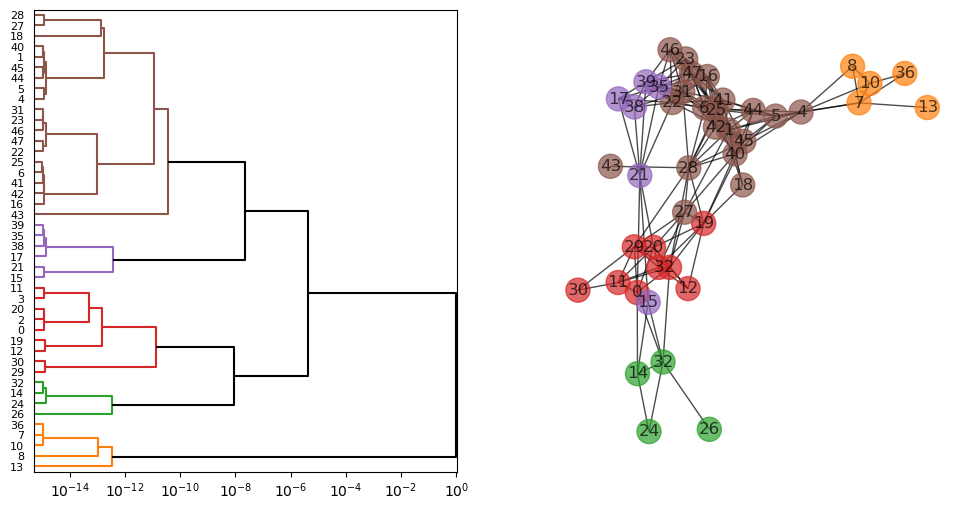

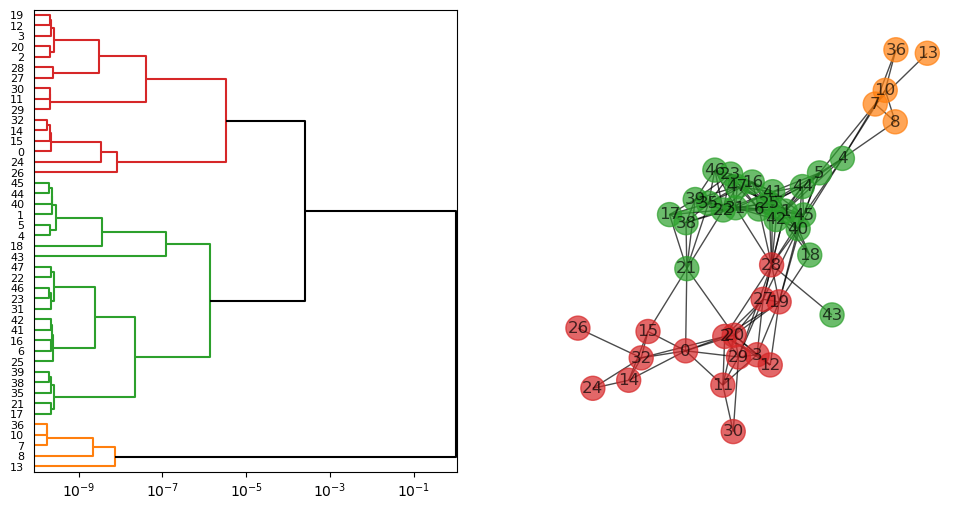

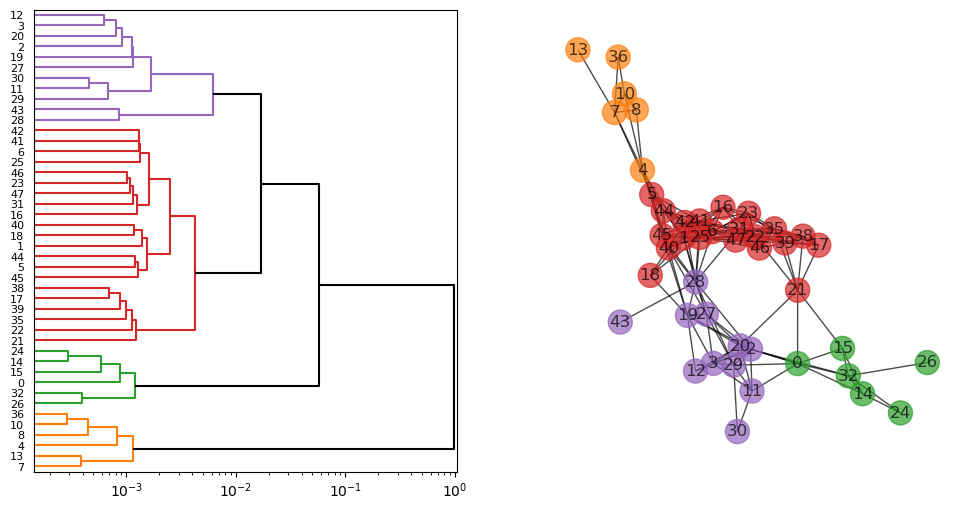

In [8]:
partitions = []
tau_values = [1/100, 1/max(spectrum), 1]  # Example τ values for different stages.
thresholds = [1e-9, 1e-4, 1e-2]  # Example thresholds for different stages.
# Sample usage (replace these example partitions with your own computed clusters):
for i,tau in enumerate(tau_values):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    dists = symmetrized_inverse_distance(tau, rho_m)
    linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')
    #
    threshold = thresholds[i]
    tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
    optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
    partitions.append(optimal_clusters)

    dendro = dendrogram(linkage_matrix, ax=ax[0], 
                        color_threshold=threshold,
                        above_threshold_color='k',
                        orientation='right', labels=label_list)
    leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
    node_colors = [leaf_label_colors[label] for _,label in enumerate(label_list)]
    ax[0].set_xscale('log')
    ax[0].set_xlim(tmin)
    nx.draw(G, ax=ax[1], node_color=node_colors, with_labels=True, alpha=0.7)

In [9]:
# Example for a network with 10 nodes and 3 τ time scales.
plot_sankey(partitions, tau_values)
partdict_tau = identify_switching_nodes(partitions, tau_values)

In [10]:
partdict_tau

{0: [(0.01, 3), (0.07485407993726223, 3), (1.0, 2)],
 1: [(0.01, 5), (0.07485407993726223, 2), (1.0, 3)],
 2: [(0.01, 3), (0.07485407993726223, 3), (1.0, 4)],
 3: [(0.01, 3), (0.07485407993726223, 3), (1.0, 4)],
 4: [(0.01, 5), (0.07485407993726223, 2), (1.0, 1)],
 5: [(0.01, 5), (0.07485407993726223, 2), (1.0, 3)],
 6: [(0.01, 5), (0.07485407993726223, 2), (1.0, 3)],
 10: [(0.01, 3), (0.07485407993726223, 3), (1.0, 4)],
 11: [(0.01, 3), (0.07485407993726223, 3), (1.0, 4)],
 13: [(0.01, 2), (0.07485407993726223, 3), (1.0, 2)],
 14: [(0.01, 4), (0.07485407993726223, 3), (1.0, 2)],
 15: [(0.01, 5), (0.07485407993726223, 2), (1.0, 3)],
 16: [(0.01, 4), (0.07485407993726223, 2), (1.0, 3)],
 17: [(0.01, 5), (0.07485407993726223, 2), (1.0, 3)],
 18: [(0.01, 3), (0.07485407993726223, 3), (1.0, 4)],
 19: [(0.01, 3), (0.07485407993726223, 3), (1.0, 4)],
 20: [(0.01, 4), (0.07485407993726223, 2), (1.0, 3)],
 21: [(0.01, 5), (0.07485407993726223, 2), (1.0, 3)],
 22: [(0.01, 5), (0.074854079937262

In [ ]:
n_regions = 3
region_sizes = 10
number_of_nodes = region_sizes*n_regions

In [ ]:
ts, t, region_labels = generate_brain_timeseries_4(n_regions=n_regions, region_sizes=region_sizes, return_time=True, n_timepoints=1000, return_labels=True, weight_distribution='powerlaw', alpha=2.5, seed=42)
node_to_region_map = dict(zip(list(range(number_of_nodes)), region_labels))

In [ ]:
for i in range(10):
    plt.plot(ts[i])

plt.xlim(800, 1000)

In [ ]:
corr = compute_correlation_matrix(ts)
corr = corr - np.diag(np.diag(corr))  # Remove diagonal for visualization
corr[corr < 0] = 0  # Set negative correlations to zero
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title("Functional Connectivity (Correlation Matrix)")
plt.xlabel("Region")
plt.ylabel("Region")
plt.show()

In [ ]:
G = nx.from_numpy_array(corr)

In [ ]:
Th, Einf, Pinf = compute_threshold_stats(G)

In [ ]:
plt.plot(Th, Pinf)
plt.plot(Th, Einf)

In [ ]:
best_th = 0.001

In [ ]:
C_th = corr.copy()
C_th[corr < best_th] = 0
G0 = nx.from_numpy_array(C_th)
G0 = get_giant_component(G0)

In [ ]:
L = nx.laplacian_matrix(G0).todense()
spectrum = nx.laplacian_spectrum(G0)
#
fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(G0, with_labels=True, alpha=0.7)

In [ ]:
def rho_matrix(tau):
    num = expm(-tau * L)
    den = np.trace(num)
    return num / den
Sm1, Csp, VarL, t = entropy(spectrum, steps=600, t1=-2, t2=5)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 4))
#
color1 = "blue"
color2 = "red"
#
ax1.plot(t, Sm1, label=r"$1-S$", color=color1)
ax1.set_ylabel("1-S", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xscale('log')
ax2 = ax1.twinx()
ax2.plot(t[:-1], Csp, label=r"$C$", color=color2)
ax2.set_ylabel("C", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_xlabel(r"$\tau$")
#
fig.tight_layout()

In [ ]:
max(spectrum)

In [ ]:
tau = 0.01

In [ ]:
Trho = 1.0 / rho_matrix(tau)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
#
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G0, method='ward')

In [ ]:
threshold = 0.0001
optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
#
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
dendro = dendrogram(linkage_matrix, ax=ax[0], 
                    color_threshold=threshold,
                    above_threshold_color='k',
                    orientation='right')
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[str(label)] for label,_ in enumerate(label_list)]
ax[0].set_xscale('log')
ax[0].set_xlim(tmin)
nx.draw(G0, ax=ax[1], node_color=node_colors, alpha=0.7)

In [ ]:
tau = 1/max(spectrum)

In [ ]:
Trho = 1.0 / rho_matrix(tau)
Trho = np.maximum(Trho, Trho.T)
np.fill_diagonal(Trho, 0)
#
dists = squareform(Trho)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G0, method='ward')

In [ ]:
threshold = 0.01
optimal_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
#
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]
dendro = dendrogram(linkage_matrix, ax=ax[0], 
                    color_threshold=threshold,
                    above_threshold_color='k',
                    orientation='right')
leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
node_colors = [leaf_label_colors[str(label)] for label,_ in enumerate(label_list)]
ax[0].set_xscale('log')
ax[0].set_xlim(tmin)
nx.draw(G0, ax=ax[1], node_color=node_colors, alpha=0.7)